In [2]:
!mkdir result

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy
import seaborn as sns 
import matplotlib.pyplot as plt

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            if self.use_bn:
                x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
     


In [176]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class CNN(nn.Module):
    def __init__(self, model_code, in_channels, out_dim, fc_layer, hid_dim, act, use_bn, dropout, use_he):
        super(CNN, self).__init__()

        self.model_code = model_code
        self.in_channels = in_channels
        self.out_dim = out_dim
        self.fc_layer = fc_layer
        self.hid_dim = hid_dim
        self.use_bn = use_bn
        self.dropout = dropout
        self.HE = use_he
        
        if act == 'relu':
            self.act = nn.ReLU()
        elif act == 'tanh':
            self.act = nn.Tanh()
        elif act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected')

        self.layers = self._make_layers()
        self.fc = self._make_fc_layers()
        
        if self.HE:
            self._initialize_weights()
        
    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def _make_layers(self):
        layers = []
        for x in cfg[self.model_code]:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels=self.in_channels, out_channels=x, kernel_size=3, stride=1, padding=1)]
                if self.use_bn:
                    layers += [nn.BatchNorm2d(x)]
                layers += [self.act]
                self.in_channels = x  
        return nn.Sequential(*layers)

    def _make_fc_layers(self):
        fc_layers = []
        fc_layers.append(nn.Linear(512, self.hid_dim))
        fc_layers.append(self.act)
        if self.dropout > 0:
            fc_layers.append(nn.Dropout(self.dropout))
        
        for _ in range(self.fc_layer):
            fc_layers.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                fc_layers.append(nn.BatchNorm1d(self.hid_dim))
            fc_layers.append(self.act)
            if self.dropout > 0:
                fc_layers.append(nn.Dropout(self.dropout))

        fc_layers.append(nn.Linear(self.hid_dim, self.out_dim))
        return nn.Sequential(*fc_layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

In [45]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        # get the inputs
        inputs, labels = data     
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [7]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc
     

In [143]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [163]:
def experiment(partition, args):

    
    net = CNN(model_code = args.model_code,
              in_channels = args.in_channels,
              out_dim = args.out_dim,
              fc_layer = args.fc_layer,
              hid_dim = args.hid_dim,
              act = args.act,
              use_bn = args.use_bn,
              dropout = args.dropout,
              use_he = args.use_he)
              
    
    
    net.cuda()
    print('{} parameters'.format(sum(p.numel() for p in net.parameters() if p.requires_grad)))
    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

In [164]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './result/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './result'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [203]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.tight_layout()
   


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.tight_layout()
    

## Experiment 1

In [178]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr_model_code"

# ====== Model ====== #
#args.model_code = 'VGG11'
args.in_channels = 3
args.out_dim = 10
args.fc_layer = 3
args.hid_dim = 100
args.act = 'relu'
args.dropout = 0.3

# ====== Regularization ======= #
args.l2 = 0.00001
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam'
#args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'model_code'
list_var1 = [0.0005]
list_var2 = ['VGG11', 'VGG16']


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp1_lr_model_code', in_channels=3, out_dim=10, fc_layer=3, hid_dim=100, act='relu', dropout=0.3, l2=1e-05, use_bn=True, optim='Adam', epoch=10, train_batch_size=512, test_batch_size=1024, lr=0.0005, model_code='VGG11')
9309194 parameters
Epoch 0, Acc(train/val): 24.21/36.39, Loss(train/val) 1.97/1.65. Took 15.57 sec
Epoch 1, Acc(train/val): 41.16/46.12, Loss(train/val) 1.53/1.45. Took 15.59 sec
Epoch 2, Acc(train/val): 51.82/50.79, Loss(train/val) 1.27/1.38. Took 15.61 sec
Epoch 3, Acc(train/val): 60.89/62.45, Loss(train/val) 1.08/1.10. Took 15.60 sec
Epoch 4, Acc(train/val): 69.13/66.79, Loss(train/val) 0.91/1.00. Took 15.59 sec
Epoch 5, Acc(train/val): 74.37/67.98, Loss(train/val) 0.79/0.92. Took 15.63 sec
Epoch 6, Acc(train/val): 77.52/65.36, Loss(train/val) 0.71/1.20. Took 15.76 sec
Epoch 7, Acc(train/val): 81.72/73.01, Loss(train/val) 0.60/0.90. Took 15.79 sec
Epoch 8, Acc(train/val): 83.33/75.45, Loss(train/val) 0.55/0.82. Took 15.62 sec
Epoch 9, Acc(train/va

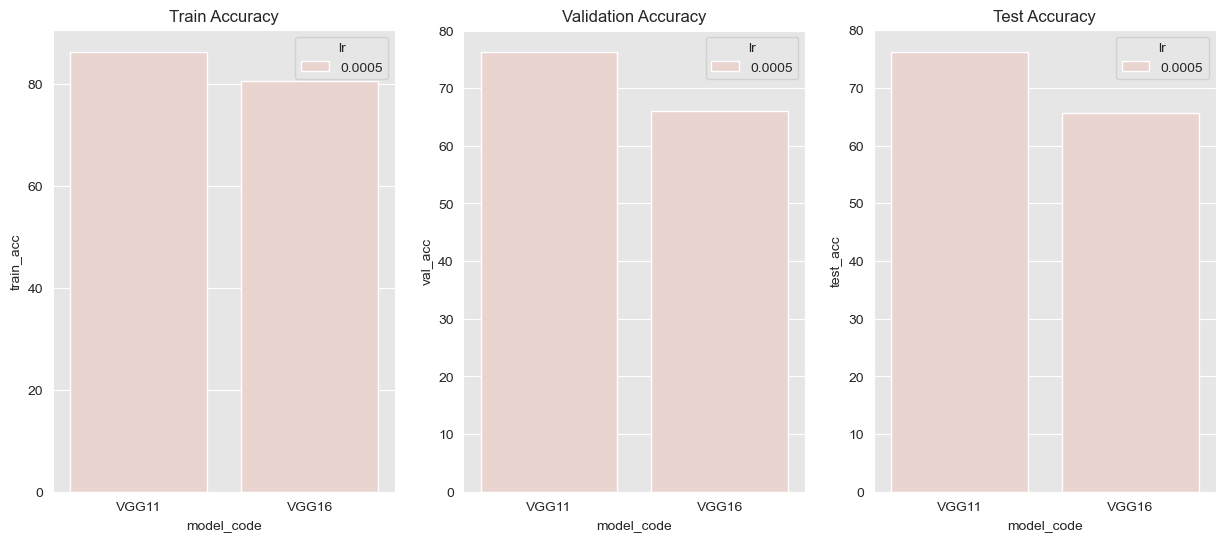

In [206]:
df = load_exp_result('exp1_lr_model_code')
df = df.loc[df['optim'] == 'Adam' ,:]
var1 = 'model_code'
var2 = 'lr'
plot_acc(var1, var2, df_sub)

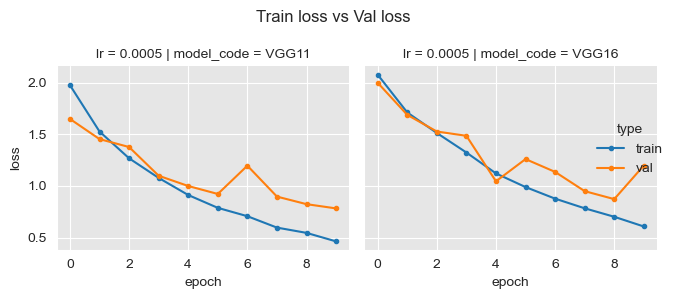

In [207]:
plot_loss_variation(var1, var2, df)

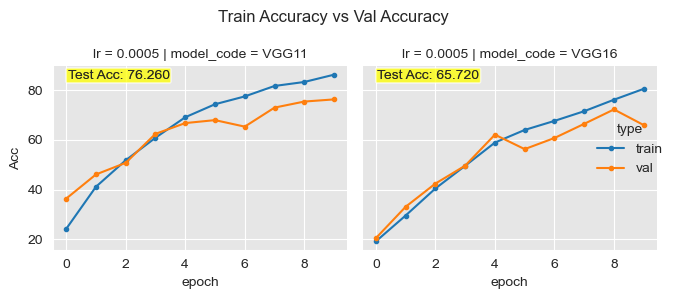

In [208]:
plot_acc_variation(var1, var2, df)

## Experiment 2

In [202]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_fc_layer_dropout"

# ====== Model ====== #
#args.model_code = 'VGG11'
args.in_channels = 3
args.out_dim = 10
#args.fc_layer = 3
args.hid_dim = 100
args.act = 'relu'
#args.dropout = 0.3

# ====== Regularization ======= #
args.l2 = 0.00001
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam'
args.lr = 0.0005
args.epoch = 10
args.model_code = 'VGG11'

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'dropout'
name_var2 = 'fc_layer'
list_var1 = [0,0.1,0.3,0.5]
list_var2 = [1,2,3]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp2_fc_layer_dropout', in_channels=3, out_dim=10, hid_dim=100, act='relu', l2=1e-05, use_bn=True, optim='Adam', lr=0.0005, epoch=10, model_code='VGG11', train_batch_size=512, test_batch_size=1024, dropout=0, fc_layer=1)
9288594 parameters
Epoch 0, Acc(train/val): 52.54/56.20, Loss(train/val) 1.37/1.24. Took 15.72 sec
Epoch 1, Acc(train/val): 69.83/64.00, Loss(train/val) 0.89/1.04. Took 15.59 sec
Epoch 2, Acc(train/val): 77.02/69.36, Loss(train/val) 0.68/0.91. Took 15.63 sec
Epoch 3, Acc(train/val): 82.77/70.97, Loss(train/val) 0.51/0.86. Took 15.56 sec
Epoch 4, Acc(train/val): 87.28/73.36, Loss(train/val) 0.39/0.81. Took 15.59 sec
Epoch 5, Acc(train/val): 90.52/73.70, Loss(train/val) 0.29/0.84. Took 15.60 sec
Epoch 6, Acc(train/val): 93.21/70.14, Loss(train/val) 0.21/1.03. Took 15.59 sec
Epoch 7, Acc(train/val): 94.53/64.95, Loss(train/val) 0.17/1.32. Took 15.57 sec
Epoch 8, Acc(train/val): 96.66/76.35, Loss(train/val) 0.11/0.83. Took 15.61 sec
Epoch 9, Acc(train/v

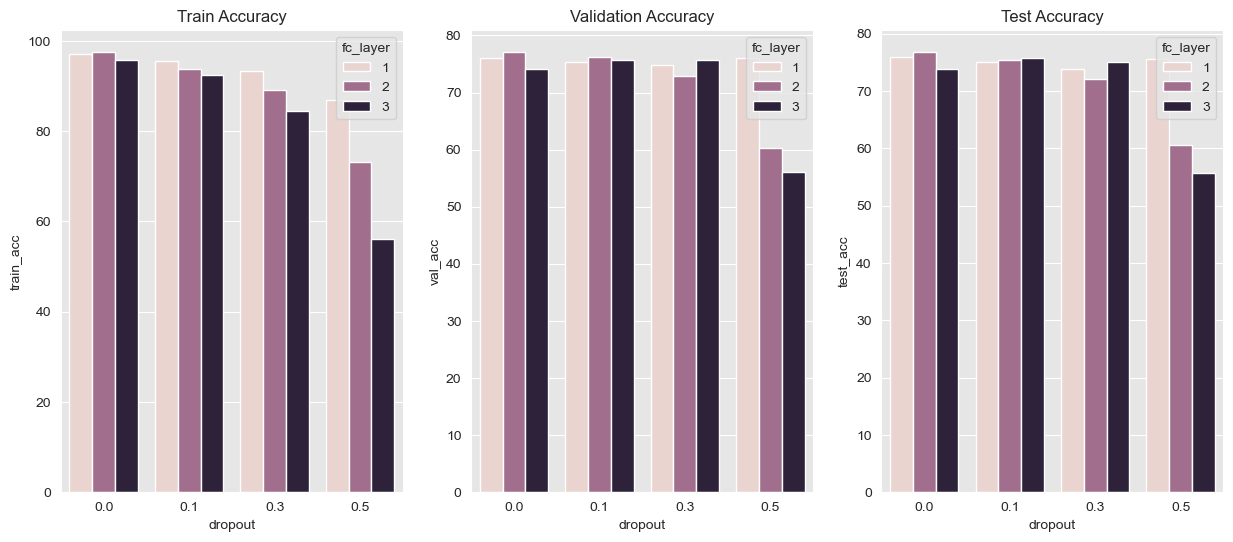

In [214]:
df = load_exp_result('exp2_fc_layer_dropout')
var1 = 'dropout'
var2 = 'fc_layer'
plot_acc(var1, var2, df)

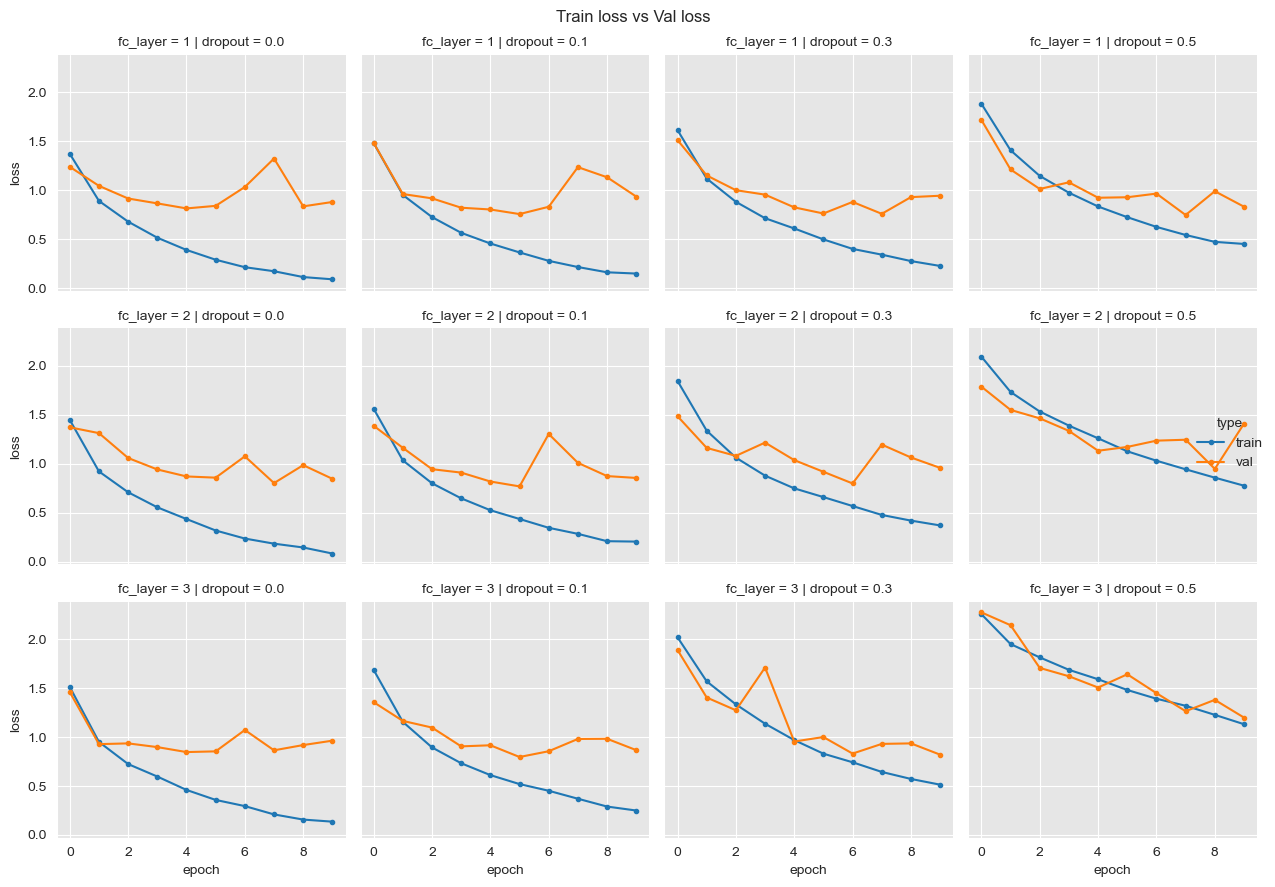

In [215]:
plot_loss_variation(var1, var2, df)

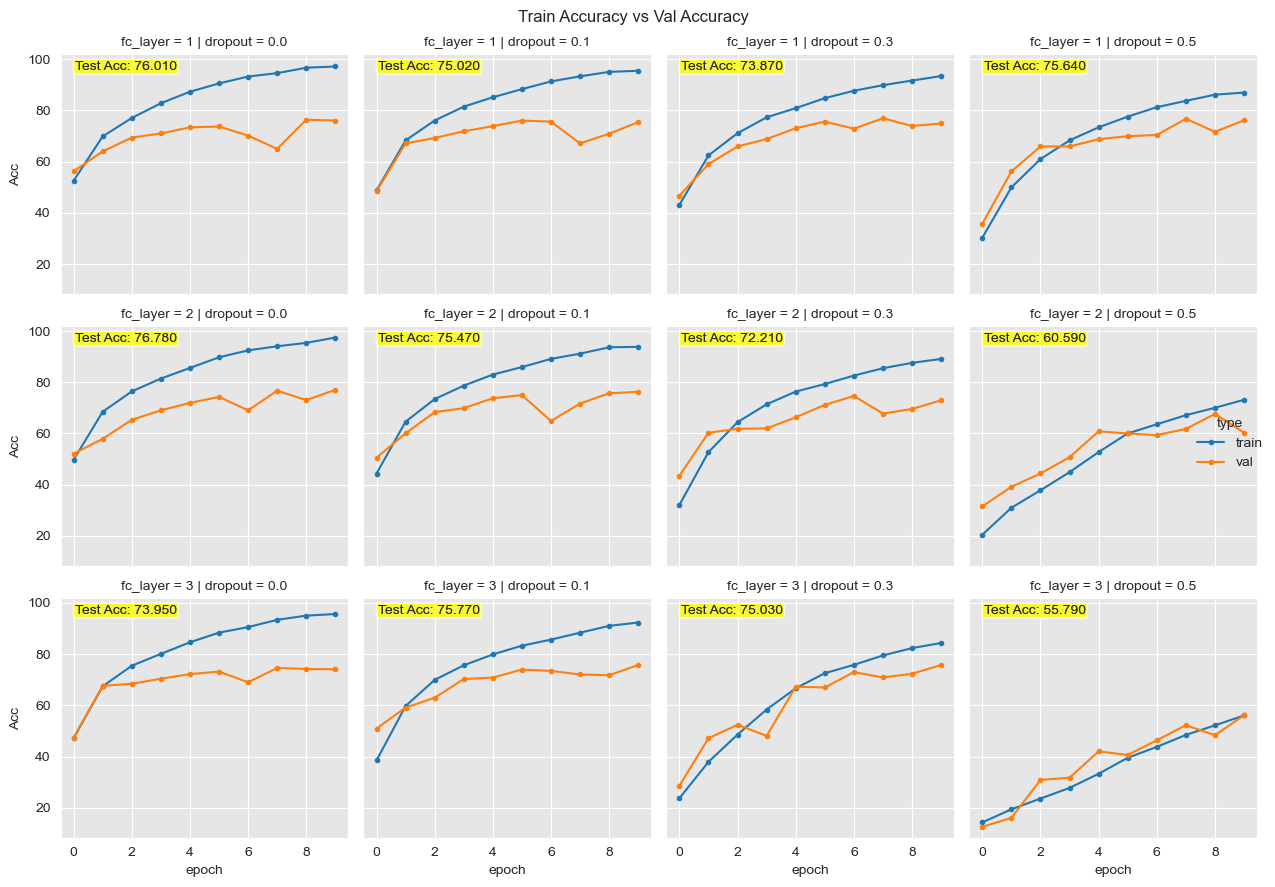

In [216]:
plot_acc_variation(var1, var2, df)

## Experiment 3

In [218]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp3_optim_use_he"

# ====== Model ====== #
args.model_code = 'VGG11'
args.in_channels = 3
args.out_dim = 10
args.fc_layer = 1
args.hid_dim = 100
args.act = 'relu'
args.dropout = 0.5
#args.use_he = True

# ====== Regularization ======= #
args.l2 = 0.00001
args.use_bn = True

# ====== Optimizer & Training ====== #
#args.optim = 'Adam'
args.lr = 0.0005
args.epoch = 10
args.model_code = 'VGG11'

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'optim'
name_var2 = 'use_he'
list_var1 = ['RMSprop', 'Adam']
list_var2 = [False, True]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp3_optim_use_he', model_code='VGG11', in_channels=3, out_dim=10, fc_layer=1, hid_dim=100, act='relu', dropout=0.5, l2=1e-05, use_bn=True, lr=0.0005, epoch=10, train_batch_size=512, test_batch_size=1024, optim='RMSprop', use_he=False)
9288594 parameters
Epoch 0, Acc(train/val): 19.06/24.91, Loss(train/val) 2.01/1.99. Took 15.70 sec
Epoch 1, Acc(train/val): 31.93/14.27, Loss(train/val) 1.72/3.11. Took 15.71 sec
Epoch 2, Acc(train/val): 43.67/35.09, Loss(train/val) 1.47/1.94. Took 15.84 sec
Epoch 3, Acc(train/val): 53.23/37.09, Loss(train/val) 1.28/2.00. Took 15.57 sec
Epoch 4, Acc(train/val): 60.62/55.20, Loss(train/val) 1.12/1.28. Took 15.59 sec
Epoch 5, Acc(train/val): 66.84/33.60, Loss(train/val) 0.98/2.44. Took 15.63 sec
Epoch 6, Acc(train/val): 70.48/49.00, Loss(train/val) 0.89/1.83. Took 15.59 sec
Epoch 7, Acc(train/val): 74.06/31.63, Loss(train/val) 0.79/3.81. Took 15.53 sec
Epoch 8, Acc(train/val): 76.91/54.84, Loss(train/val) 0.71/1.55. Took 15.45 sec
Epoch

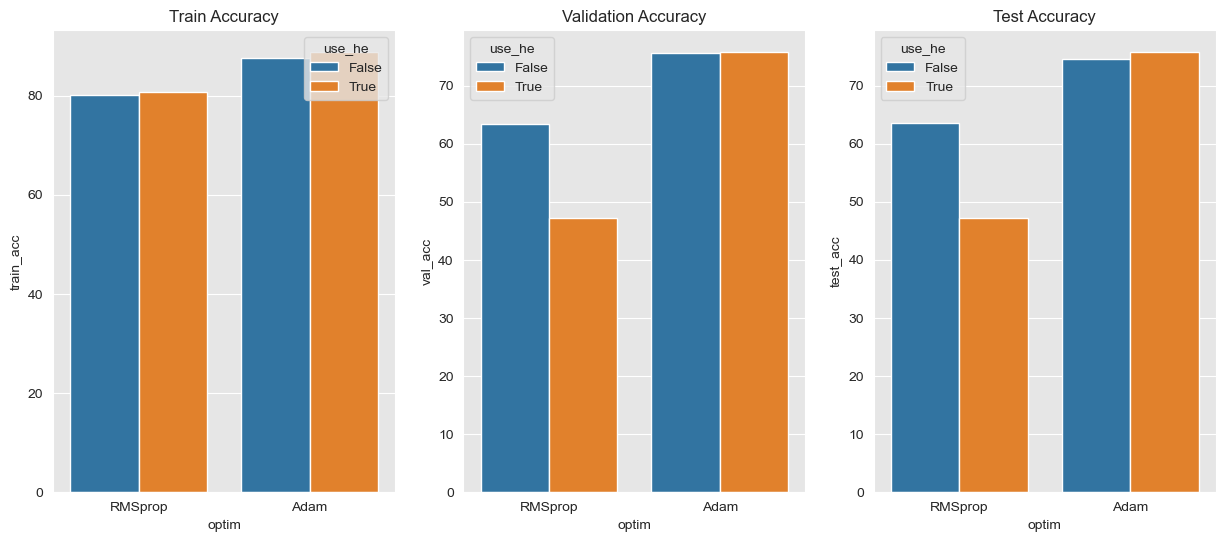

In [219]:
df = load_exp_result("exp3_optim_use_he")
var1 = 'optim'
var2 = 'use_he'
plot_acc(var1, var2, df)

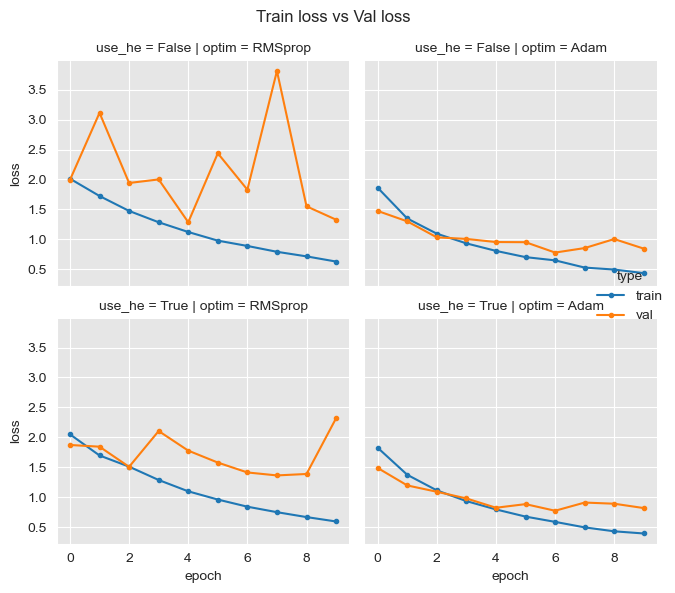

In [220]:
plot_loss_variation(var1, var2, df)

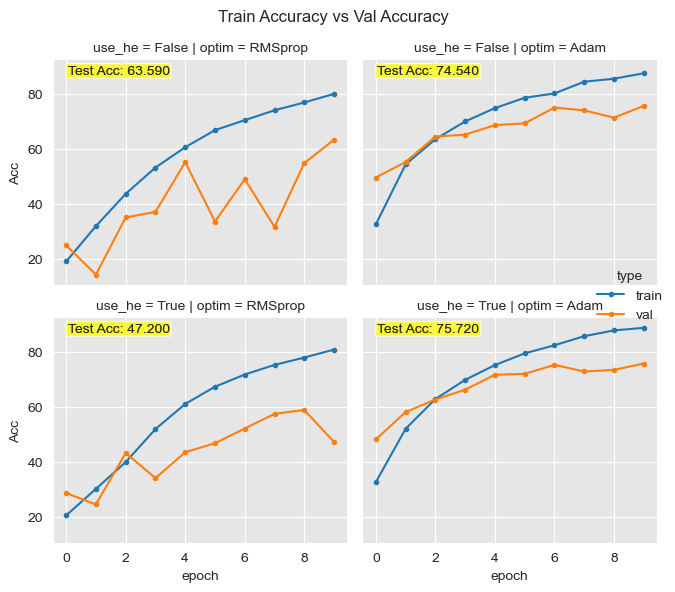

In [221]:
plot_acc_variation(var1, var2, df)